#**Import Essential Libraries**

The following Python Libraries are critical in the execution of the correlation analysis to be carried out;

**i.   ee**: Access and process Earth Engine data.

**ii.  xarray**: Handle and analyze multi-dimensional geospatial data.

**iii. xee**: Integrate Earth Engine data into xarray for advanced analysis.

In [ ]:
import ee
import xarray as xr

In [ ]:
!pip install xee
import xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00


Insert your ProjectID from Earth Engine

In [ ]:
ee.Authenticate()
ee.Initialize(project = '----------', opt_url = 'https://earthengine-highvolume.googleapis.com')

#**Area of Interest**

Now we load a global administrative boundaries dataset, **FAO GAUL Level 2 Administrative Boundaries Dataset**, filter it to isolate **Nairobi County** in **Kenya**, and extracts its geometry for use as a region of interest in subsequent geospatial analyses.

In [ ]:
# Load the FAO GAUL Level 2 Administrative Boundaries Dataset
gaul = ee.FeatureCollection('FAO/GAUL/2015/level2')

# Filter the dataset for any County in Kenya
roi = gaul.filter(ee.Filter.And(
    ee.Filter.eq('ADM0_NAME', 'Kenya'),
    ee.Filter.eq('ADM2_NAME', 'Nairobi')
))

roi = roi.geometry()

#**TerraClimate: Monthly Climate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho**

The **TerraClimate** Dataset provides monthly climate and climatic water balance for global terrestrial surfaces.

It uses climatically aided interpolation, combining high-spatial resolution climatological normals from the **WorldClim** dataset, with coarser spatial resolution, but time-varying data from CRU Ts4.0 and the Japanese 55-year Reanalysis (JRA55).

For primary climate variables of temperature, vapor pressure, and precipitation, the University of Idaho provides additional data on the number of stations (between 0 and 8) that contributed to the CRU Ts4.0 data used by TerraClimate. JRA55 was used exclusively for solar radiation and wind speeds.

TerraClimate additionally produces monthly surface water balance datasets using a water balance model that incorporates reference evapotranspiration, precipitation, temperature, and interpolated plant extractable soil water capacity.

A modified Thornthwaite-Mather climatic water-balance model and extractable soil water storage capacity data was used at a 0.5° grid from Wang-Erlandsson et al. (2016).

**Major Characteristics of the TerraClimate Dataset:**


1. It has a cadence(temporal resolution) of 1-month.

2. At the time of this publication, its availability spans from 1958-01-01 to 2024-12-01.

3. It has a spatial resolution of approximately 5 kilometers but specifically 4638.3 meters.

* For this case study, we are interested in the cumulative precipitation and average
temperature of Nairobi County.

* As such, the **pr** band(**Precipitation**) can be used to derive the Annual
  Cumulative Precipitation from 2010 to 2019.

* Furthermore, the **tmmn**(**Minimum temperature**) and **tmmx**(**Maximum temperature**) bands can be combined to derive the Annual Average Temperature from 2010 to 2019.

We load a global climate dataset (**TerraClimate**) from Earth Engine, filter it by date and select specific climate variables, and convert it into an **xarray** dataset using the xr.open_dataset() function for further analysis.

The data is spatially constrained to a specific region (ROI), Nairobi County, and resampled to a defined resolution. The scale being 0.05 Degrees is equivalent to approximately 5000 meters which is the approximate resolution of the TerraClimate Dataset.

Please note: **1 Degree = 100 Kilometers** and in defining the scale we utilize angular units over scalar units like meters or kilometers. Thus, the use of 0.05 Degrees.

In [ ]:
col = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE").filterDate('2010', '2020').select('pr', 'tmmn', 'tmmx')

In [ ]:
ds = xr.open_dataset(col, engine = 'ee', crs = 'EPSG:4326', scale = 0.05, geometry = roi)

In [ ]:
ds

<xarray.Dataset> Size: 79kB
Dimensions:  (time: 120, lon: 9, lat: 6)
Coordinates:
  * time     (time) datetime64[ns] 960B 2010-01-01 2010-02-01 ... 2019-12-01
  * lon      (lon) float64 72B 36.69 36.74 36.79 36.84 ... 36.99 37.04 37.09
  * lat      (lat) float64 48B -1.418 -1.368 -1.318 -1.268 -1.218 -1.168
Data variables:
    pr       (time, lon, lat) float32 26kB ...
    tmmn     (time, lon, lat) float32 26kB ...
    tmmx     (time, lon, lat) float32 26kB ...
Attributes: (12/19)
    date_range:               [-378691200000, 1606780800000]
    description:              <p>TerraClimate is a dataset of monthly climate...
    keywords:                 ['climate', 'drought', 'evapotranspiration', 'g...
    period:                   0
    product_tags:             ['climate', 'global', 'monthly', 'geophysical',...
    provider:                 University of California Merced
    ...                       ...
    visualization_0_bands:    tmmx
    visualization_0_max:      300.0
    visualization_0_min:      -300.0
    visualization_0_name:     Maximum Temperature
    visualization_0_palette:  1a3678,2955bc,5699ff,8dbae9,acd1ff,caebff,e5f9f...
    crs:                      EPSG:4326

#**Annual Cumulative Precipitation Analysis in Nairobi County, Kenya - 2010-2019**

Now, we compute the annual cumulative precipitation from 2010 to 2019 using the sum aggregation year by year.

In [ ]:
pr_annual = ds.pr.resample(time = 'YE').sum('time')

In [ ]:
pr_annual

<xarray.DataArray 'pr' (time: 10, lon: 9, lat: 6)> Size: 2kB
array([[[ 784.,  807.,  828.,  834.,  872.,  939.],
        [ 756.,  830.,  850.,  855.,  876.,  933.],
        [ 717.,  807.,  868.,  904.,  854.,  908.],
        [ 615.,  658.,  813.,  826.,  742.,  786.],
        [ 565.,  627.,  667.,  669.,  681.,  731.],
        [ 546.,  592.,  615.,  628.,  644.,  671.],
        [ 533.,  575.,  595.,  612.,  625.,  657.],
        [ 527.,  565.,  583.,  596.,  621.,  646.],
        [ 553.,  569.,  584.,  608.,  629.,  649.]],

       [[ 701.,  715.,  735.,  747.,  789.,  866.],
        [ 670.,  734.,  752.,  760.,  784.,  851.],
        [ 639.,  719.,  768.,  801.,  763.,  827.],
        [ 554.,  589.,  719.,  729.,  667.,  716.],
        [ 506.,  562.,  599.,  604.,  618.,  669.],
        [ 493.,  545.,  561.,  576.,  589.,  621.],
        [ 492.,  536.,  554.,  565.,  577.,  609.],
        [ 494.,  534.,  549.,  558.,  581.,  606.],
        [ 526.,  546.,  562.,  583.,  602.,  623.]],

...

       [[1343., 1363., 1392., 1396., 1461., 1594.],
        [1286., 1414., 1443., 1443., 1477., 1591.],
        [1214., 1371., 1480., 1540., 1442., 1546.],
        [1017., 1090., 1384., 1399., 1234., 1307.],
        [ 905., 1023., 1093., 1089., 1111., 1196.],
        [ 862.,  952.,  983., 1003., 1021., 1077.],
        [ 833.,  907.,  936.,  956.,  977., 1041.],
        [ 820.,  873.,  893.,  915.,  957., 1008.],
        [ 843.,  856.,  869.,  904.,  945.,  974.]],

       [[1144., 1148., 1164., 1161., 1202., 1287.],
        [1101., 1189., 1201., 1208., 1227., 1295.],
        [1044., 1153., 1220., 1260., 1199., 1272.],
        [ 866.,  912., 1098., 1113., 1017., 1070.],
        [ 758.,  859.,  914.,  914.,  921.,  968.],
        [ 712.,  812.,  841.,  846.,  851.,  879.],
        [ 684.,  773.,  802.,  810.,  817.,  848.],
        [ 687.,  746.,  768.,  781.,  803.,  829.],
        [ 732.,  743.,  759.,  793.,  820.,  826.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 72B 36.69 36.74 36.79 36.84 ... 36.99 37.04 37.09
  * lat      (lat) float64 48B -1.418 -1.368 -1.318 -1.268 -1.218 -1.168
  * time     (time) datetime64[ns] 80B 2010-12-31 2011-12-31 ... 2019-12-31
Attributes:
    id:             pr
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': -32768, ...
    dimensions:     [8640, 4320]
    crs:            EPSG:4326
    crs_transform:  [0.041666666666666664, 0, -180, 0, -0.041666666666666664,...

Here, we visually plot the Annual Cumulative Precipitation Maps of Nairobi County from 2010 to 2019 derived from the above code using the matplotlib library.

In [ ]:
import matplotlib.pyplot as plt

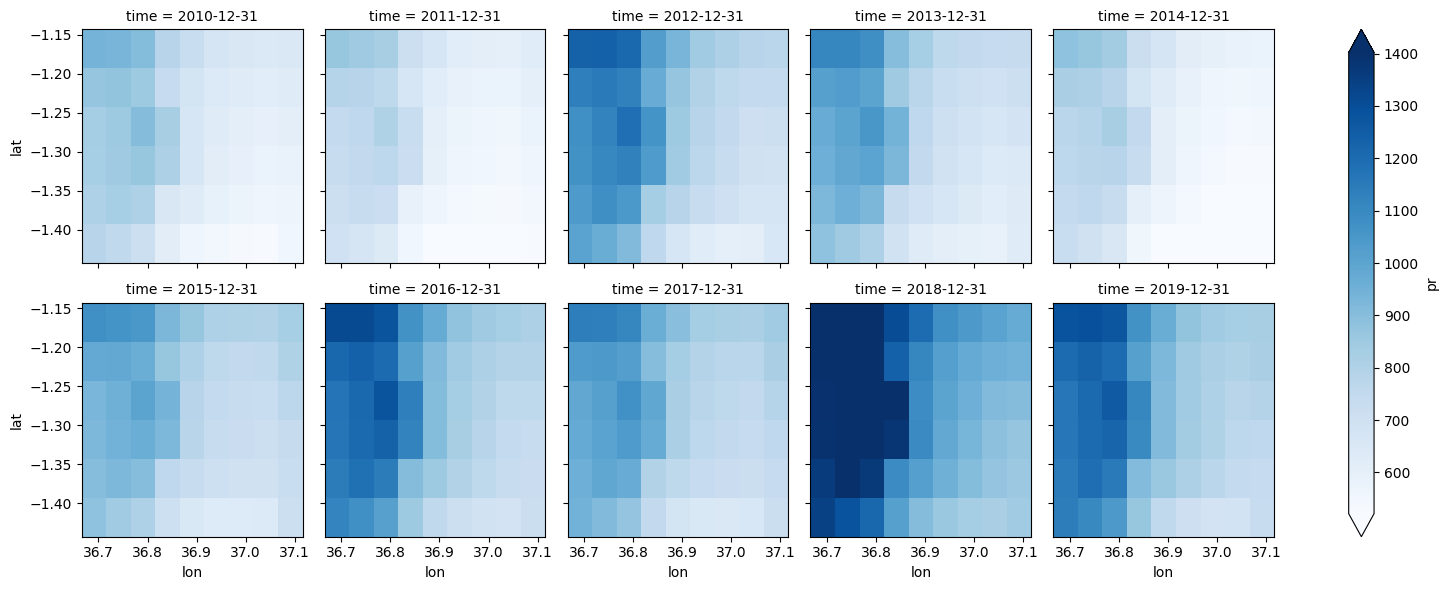

In [ ]:
pr_annual.plot(x = 'lon', y = 'lat', cmap = 'Blues', col = 'time', col_wrap = 5, robust = True)

#**Annual Mean Temperature Analysis in Nairobi County, Kenya 2010-2019**

Using the Minimum and Maximum Variables in the dataset na dfactoring in the provided scale factor of 0.1 for both bands in the TerraClimate Dataset Description, the mean temperature can be computed as follows;

                            ((Min + Max)/2) * 0.1

In [ ]:
temp = (((ds.tmmn + ds.tmmx)/2) * 0.1).round(2).rename('temp')

In [ ]:
temp_annual = temp.resample(time = 'YE').mean('time')

In [ ]:
temp_annual

<xarray.DataArray 'temp' (time: 10, lon: 9, lat: 6)> Size: 2kB
array([[[18.829168, 18.483332, 18.383335, 18.229168, 17.875002,
         17.533335],
        [19.254166, 18.8125  , 18.908333, 18.849998, 18.720835,
         18.25    ],
        [19.429167, 19.270832, 19.229168, 19.216665, 19.358332,
         18.916666],
        [20.025   , 20.062498, 20.545834, 20.254168, 19.866669,
         20.008333],
        [20.441666, 20.308332, 20.6875  , 20.741667, 20.354166,
         20.241669],
        [20.929167, 20.533333, 20.800001, 20.9125  , 20.84167 ,
         20.533335],
        [21.125   , 20.745834, 20.791668, 20.991667, 21.029167,
         20.762499],
        [21.041666, 20.941668, 20.924997, 21.1375  , 21.129168,
         21.116667],
        [20.4875  , 21.041666, 21.108332, 21.1     , 21.008333,
         21.116667]],

       [[18.725   , 18.387499, 18.291666, 18.141666, 17.779167,
...
         19.841667]],

       [[19.404167, 19.0375  , 18.937502, 18.766668, 18.395834,
         18.0375  ],
        [19.825   , 19.362501, 19.449999, 19.404167, 19.254168,
         18.762499],
        [19.987501, 19.833334, 19.77917 , 19.754168, 19.895834,
         19.425   ],
        [20.574999, 20.604166, 21.1125  , 20.795835, 20.391668,
         20.5     ],
        [20.995832, 20.85    , 21.233332, 21.2625  , 20.870836,
         20.750002],
        [21.479166, 21.074999, 21.324999, 21.429169, 21.358332,
         21.045834],
        [21.670832, 21.275002, 21.33333 , 21.520834, 21.541666,
         21.245832],
        [21.595833, 21.479166, 21.470833, 21.670832, 21.629166,
         21.616667],
        [21.025002, 21.574999, 21.633333, 21.620832, 21.5     ,
         21.6     ]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 72B 36.69 36.74 36.79 36.84 ... 36.99 37.04 37.09
  * lat      (lat) float64 48B -1.418 -1.368 -1.318 -1.268 -1.218 -1.168
  * time     (time) datetime64[ns] 80B 2010-12-31 2011-12-31 ... 2019-12-31

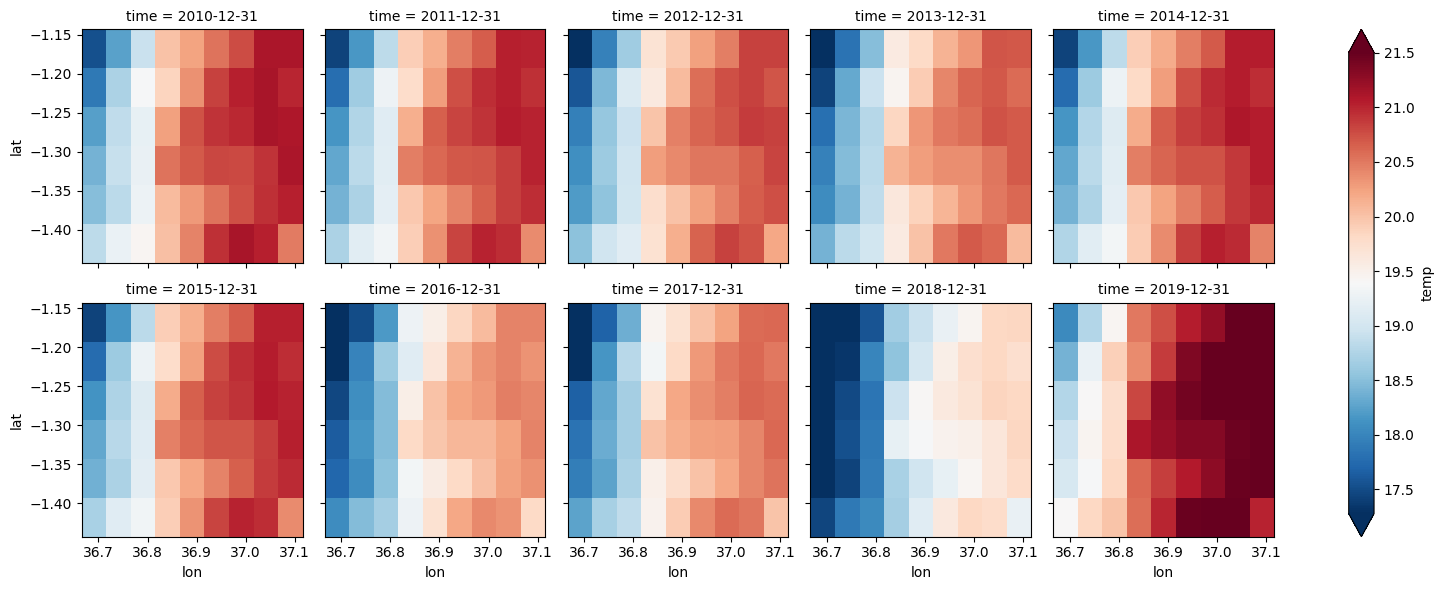

In [ ]:
temp_annual.plot(x = 'lon', y = 'lat', col = 'time', col_wrap = 5, cmap = 'RdBu_r', robust = True)

#**Correlation Between Precipitation and Temperature From 2010 to 2019 in Nairobi County**

**xr.corr():**

This is an xarray function that computes the **Pearson correlation coefficient** between two DataArray objects.

The correlation coefficient measures the linear relationship between the two variables, ranging from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

Here, the correlation is computed over the **time dimension**, meaning it calculates how temperature and precipitation vary together over time at each spatial location.

In [ ]:
cor_map = xr.corr(temp_annual, pr_annual, dim = 'time')

In [ ]:
cor_map

<xarray.DataArray (lon: 9, lat: 6)> Size: 216B
array([[-0.5069561 , -0.5339278 , -0.5433584 , -0.5651411 , -0.58179927,
        -0.607833  ],
       [-0.50180066, -0.53903913, -0.55261457, -0.5443955 , -0.56317955,
        -0.59259343],
       [-0.49735135, -0.5320229 , -0.56048226, -0.5716995 , -0.55498314,
        -0.5828764 ],
       [-0.52191097, -0.5425786 , -0.5940295 , -0.59216124, -0.5717354 ,
        -0.5870392 ],
       [-0.5559652 , -0.54742587, -0.5474627 , -0.55867827, -0.57147807,
        -0.60378826],
       [-0.5677367 , -0.5339892 , -0.5336524 , -0.5595963 , -0.57136554,
        -0.6044132 ],
       [-0.5804689 , -0.5393109 , -0.5308771 , -0.5536466 , -0.57814497,
        -0.6089457 ],
       [-0.54533327, -0.5305065 , -0.53054565, -0.5393783 , -0.57114965,
        -0.6031644 ],
       [-0.50090516, -0.49351016, -0.49648967, -0.5025935 , -0.51984984,
        -0.5515491 ]], dtype=float32)
Coordinates:
  * lon      (lon) float64 72B 36.69 36.74 36.79 36.84 ... 36.99 37.04 37.09
  * lat      (lat) float64 48B -1.418 -1.368 -1.318 -1.268 -1.218 -1.168

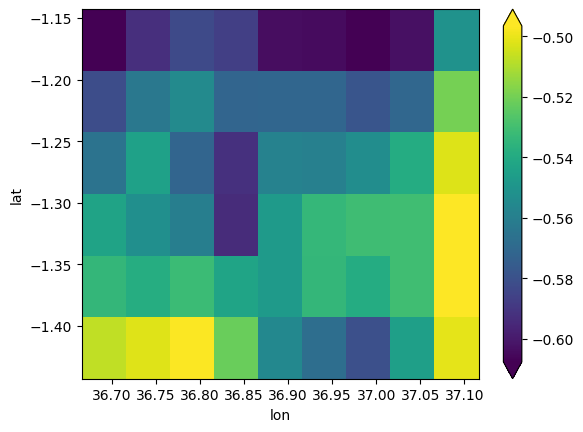

In [ ]:
cor_map.plot(x = 'lon', y = 'lat', robust = True)

#**Final Insights**



**1. Nairobi County had it's highest average temperatures in 2019 compared to all other years within the time epoch of the study especially to the Eastern Direction.**

**2. Nairobi County had it's lowest average temperatures in 2018 compared to all other years within the time epoch of the study especially to the Western Direction.**

**3. Nairobi County had it's highest cumulative precipitation in 2018 compared to all other years within the time epoch of the study especially to the Eastern Direction.**

**4. Nairobi County had it's lowest cumulative precipitation in 2011 compared to all other years within the time epoch of the study especially to the South West Direction.**

**5. Most areas in Nairobi County seem to have a strong negative correlation between Precipitation and Temperature.**

**6. More often than not, an increase is precipitation cumulatively is accompanied by a decrease in average temperature in most areas in Nairobi County from 2010 to 2019.**